In [1]:
# general
import sys, os, path
import datetime

# nn related
import torch as th
import numpy as np
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
import seaborn as sns
import tikzplotlib as tikz

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')

from scripts import preProcess as pre
from scripts import TensorBasedNN
from scripts.TensorBasedNN import TBNN_generic
from scripts.utilities import * # get_invariants, get_tensor_functions, sigmoid_scaling, mean_std_scaling
from scripts.torchToFoam import writesymmtensor
from scripts.barymap import BarMap
from scripts import *

# standard datatype
dtype = th.double

In [2]:
path = '/home/leonriccius/OpenFOAM/leonriccius-v2006/run/curved_backstep/refined/13700_ml'
rans_time = max([int(entry) for entry in os.listdir(path) if entry.isnumeric()])

In [3]:
grid_rans = pre.readCellCenters(rans_time, path)
u_rans = pre.readVectorData(rans_time, 'U', path)
u_levm = pre.readVectorData('0', 'U', path)

path_dns = '/home/leonriccius/Documents/Fluid_Data/training_data/curved_backstep/dns/13700'
grid_dns = th.load(os.sep.join([path_dns, 'grid-torch.th']))
u_dns = th.load(os.sep.join([path_dns, 'U-torch.th']))

Reading mesh cell centers /home/leonriccius/OpenFOAM/leonriccius-v2006/run/curved_backstep/refined/13700_ml/2085/cellCenters
Attempting to read file: /home/leonriccius/OpenFOAM/leonriccius-v2006/run/curved_backstep/refined/13700_ml/2085/U
Parsing file...
Data field file successfully read.
Attempting to read file: /home/leonriccius/OpenFOAM/leonriccius-v2006/run/curved_backstep/refined/13700_ml/0/U
Parsing file...
Data field file successfully read.


<ipython-input-22-2085082f71ef>:34: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
  cmap.set_over([0.70567315799999997, 0.015556159999999999, 0.15023281199999999, 1.0])
<ipython-input-22-2085082f71ef>:35: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
  cmap.set_under([0.2298057, 0.298717966, 0.75368315299999999, 1.0])


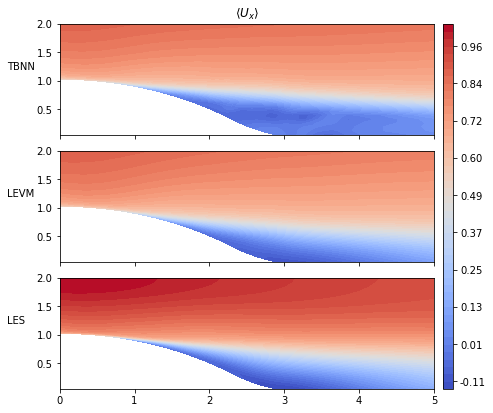

In [22]:
nrows = 3
ncols = 1
s = 1.5

idx = [0]

ref = 15
# x_min, x_max = 1.05*np.min(grid_rans[:,0].numpy()), 0.95*np.max(grid_rans[:,0].numpy())
# y_min, y_max= 1.05*np.min(grid_rans[:,1].numpy()), 0.95*np.max(grid_rans[:,1].numpy())
x_min, x_max = 0., 5.
y_min, y_max = 0.05, 2.

nx = int(ref*(x_max - x_min))
ny = int(ref*(y_max - y_min))

grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
grid_y_shifted = cbfs_interp(grid_x)*(y_max - grid_y)/y_max + grid_y

grid_u_rans = griddata(grid_rans[:,0:2], u_rans.detach().numpy()[:,idx[0]], (grid_x, grid_y_shifted), method = 'linear')
grid_u_levm = griddata(grid_rans[:,0:2], u_levm.detach().numpy()[:,idx[0]], (grid_x, grid_y_shifted), method = 'linear')
grid_u_dns = griddata(grid_dns[:,0:2], u_dns.detach().numpy()[:,idx[0]], (grid_x, grid_y_shifted), method = 'linear') #, fill_value=0.)

# get min an max of (b_pred, b_test) for colormap
tmp = th.cat((u_rans[:,idx[0]], u_dns[:,idx[0]])).detach().numpy()
b_min = np.min(tmp)
b_max = np.max(tmp)
levels = np.linspace(b_min, b_max, 50)

# # create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*4.5*ncols, s*1.25*nrows), sharex=True, sharey=True,
                       constrained_layout=True)

cmap = matplotlib.cm.get_cmap("coolwarm")
cmap.set_over([0.70567315799999997, 0.015556159999999999, 0.15023281199999999, 1.0])
cmap.set_under([0.2298057, 0.298717966, 0.75368315299999999, 1.0])

rans_plot = ax[0].contourf(grid_x, grid_y_shifted, grid_u_rans, levels = levels, cmap=cmap)
levm_plot = ax[1].contourf(grid_x, grid_y_shifted, grid_u_levm, levels = levels, cmap=cmap)
dns_plot = ax[2].contourf(grid_x, grid_y_shifted, grid_u_dns, levels = levels, cmap=cmap)

# fig.colorbar(b_dd_plot, ax=ax.flat, aspect=15*ncols*nrows, format='%.2f', pad=0.0)
fig.colorbar(rans_plot, ax=ax.flat, aspect=15*ncols*nrows, format='%.2f', pad=0.0)
# fig.colorbar(b_dns_plot, ax=ax[1], aspect=15*ncols*nrows, format='%.2f', pad=0.0)

x_off = -0.7
y_off = 1.2

ax[0].set_title(r'$\langle U_x \rangle$')

ax[0].text(x_off,y_off, r'TBNN', fontsize='medium', ha='left')
ax[1].text(x_off,y_off, r'LEVM', fontsize='medium', ha='left')
ax[2].text(x_off,y_off, r'LES', fontsize='medium', ha='left')


# save fig
fig_path = '/home/leonriccius/gkm/Masters_Thesis/Images/curved_backstep'
fig_name =  time() + '_U_x.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

In [ ]:
fig, ax = plt.subplots()
ax.scatter(grid_x, grid_y_shifted)

In [ ]:
# create figure
fig, ax = plt.subplots(5, 3, figsize=(12,8), sharex=True, sharey=True, constrained_layout=True)

for i in range(5):
    unscaled = ax[i,0].tricontourf(cellCenters[:,0], cellCenters[:,1], inv[:,i])
    mean_std = ax[i,1].tricontourf(cellCenters[:,0], cellCenters[:,1], inv_mean_std[:,i])
    sigmoid = ax[i,2].tricontourf(cellCenters[:,0], cellCenters[:,1], inv_sigmoid[:,i])
    
    cbar_unscaled = fig.colorbar(unscaled, ax=ax[i,0], format='%.1f', pad=0.0)
    cbar_mean_std = fig.colorbar(mean_std, ax=ax[i,1], format='%.1f', pad=0.0)
    cbar_sigmoid = fig.colorbar(sigmoid, ax=ax[i,2], format='%.1f', pad=0.0)
    
    cbar_unscaled.ax.locator_params(nbins=5)
    cbar_mean_std.ax.locator_params(nbins=5)
    cbar_sigmoid.ax.locator_params(nbins=5)